## Perceptron

In [2]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels: ', np.unique(y))

Class labels:  [0 1 2]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=114, stratify=y)

In [7]:
print(f'Labels count in y: {np.bincount(y)}')
print(f'Labels count in y_train: {np.bincount(y_train)}')
print(f'Labels count in y_test: {np.bincount(y_test)}')

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [12]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=114)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=114)

In [13]:
y_pred = ppn.predict(X_test_std)
print(f'Misclassified examples: {(y_test != y_pred).sum()}')

Misclassified examples: 2


In [21]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.96


In [22]:
print(f'Accuracy: {ppn.score(X_test_std, y_test):.2f}')

Accuracy: 0.96


In [25]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

<ipython-input-25-96024d297156>:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


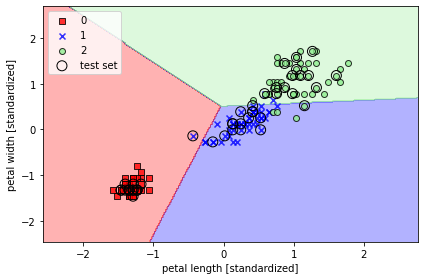

In [26]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined_std = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined_std, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()